<a href="https://colab.research.google.com/github/ragoans/E-commerce_DataWrangling/blob/main/D05_Data_Wrangling_E_commerce_(RFM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Desafio 04 - Data Cleaning e Data Wrangling de um dataset de E-commerce

### Contexto
Uma empresa do ramo de e-commerce contratou você para levantar os indicadores de recência, frequência e ticket médio (RFM) dos seus clientes. A saber RFM:
- R (Recency): Tempo que o cliente realizou a última compra (em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do ticket médio gasto pelo cliente
onde ticket médio = média do total gasto por pedido para cada cliente.

Para isso, será realizado um processo de Data Cleaning e Data Wrangling de uma base de dados (data.csv) e gerado um output em formato csv, para posterior modelagem do novo database.

### Sobre os dados
O database contém informações de compras de um e-commerce em 37 países. É composto por 8 colunas, sendo elas:
- CustomerID: Código de identificação do cliente
- Description: Descrição do produto
- InvoiceNO: Código da fatura
- StockCode: Código de estoque do produto
- Quantity: Quantidade do produto
- InvoiceDate: Data do faturamento (compra)
- UnitPrice: Preço unitário do produto
- Country: País da compra

### Objetivo
- Definir um novo dataset em formato .csv, com tratamento de dados e constando as seguintes colunas:
  - CustomerID: Código do cliente
  - R: Recência, que é a diferença em dias da última compra do cliente e da última compra disponível no conjunto de dados que calcularam previamente.
  - F: Frequência, ou seja, a quantidade de compras feitas pelo cliente.
  - M: Ticket médio, ou seja, a média das compras feitas pelo cliente.
- Realizar a plotagem de gráficos para visualização de métricas gerais de venda.

### Procedimentos
Serão realizados os seguinte procedimentos para alcançar o objetivo:
- Análise dos dados iniciais em relação a granularidade, constância e distribuição;
- Tratamento de dados nulos, caso existam, por meio de drop de colunas ou input de dados;
- Tratamento de outliers;
  - Foi informado anteriormente que a faixa de preço e quantidades usuais giram em torno de 10000 unidades e 5000 de valor unitário. Isto será considerado na correção dos outliers caso sejam identificados.
- Tratamento de dados duplicados;
- Tratamento de tipificação de colunas;
- Cálculos e colunas RFM, por meio de operações arítméticas;
- Plotagem de gráficos para visualização de variáveis:
  - Top 10 países com maior valor em vendas
  - Top 10 produtos mais vendidos
  - Valor de venda total por mês
  - Valor de venda total por mês e por país (top 10)

### Ferramentas a serem utilizadas e documentação
Seguem abaixo as ferramentas / bibliotecas a serem utilizadas, com suas respectivas documentações:
- Pandas: https://pandas.pydata.org/docs/reference/index.html
- Numpy: https://numpy.org/doc/stable/reference/
- ydata_profiling: https://docs.profiling.ydata.ai/4.5/
- Plotly: https://plotly.com/python-api-reference/
- Matplolib: https://matplotlib.org/stable/api/index.html

In [ ]:
#!pip install ydata_profiling
#!pip install sidetable

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd

from ydata_profiling import ProfileReport
import sidetable
import missingno as msno
from datetime import datetime


import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import scale



In [ ]:
# Importação e atribuição para um data frame

df = pd.read_csv('/content/drive/MyDrive/#databases/data.csv', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Inspeção do dataset
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
#ProfileReport(df)

Primeiramente, é possível inferir algumas informações a respeito do dataset:
- Existem dados nulos nas colunas de 'Description' e 'CustomerID', o que também precisa ser averiguado.
- Existem valores negativos nas colunas 'UnitPrice' e 'Quantity', o que deve ser verificado caso seja erro de lançamento e se há necessidade de dropar esses valores.
- Existem 4879 linhas duplicadas no dataset.
- A coluna de 'InvoiceDate' data precisa ser convertida para tipo de data.
- Existem prováveis outliers nas colunas 'UnitPrice' e 'Quantity', que serão analisados e tratados.
- Como existem tratamentos a serem feitos a análise de correlação ainda não permite inferir muitas informações, mas será realizada em etapas posteriores.

In [ ]:
# Identificando e tratando linhas duplicadas
df[df.duplicated(keep=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [ ]:
## Agrupando linhas duplicadas
(
  df
  .groupby(df.columns.tolist(), dropna=False)
  .size()
  .to_frame('n_duplicates')
  .query('n_duplicates > 1')
  .sort_values('n_duplicates', ascending=False)
  .head()
)

n_duplicates
InvoiceNo StockCode Description                         Quantity InvoiceDate         UnitPrice CustomerID Country                     
555524    22698     PINK REGENCY TEACUP AND SAUCER      1        2011-06-05 11:37:00 2.95      16923.0    United Kingdom            20
          22697     GREEN REGENCY TEACUP AND SAUCER     1        2011-06-05 11:37:00 2.95      16923.0    United Kingdom            12
572861    22775     PURPLE DRAWERKNOB ACRYLIC EDWARDIAN 12       2011-10-26 12:46:00 1.25      14102.0    United Kingdom             8
541266    21755     LOVE BUILDING BLOCK WORD            1        2011-01-16 16:25:00 5.95      15673.0    United Kingdom             6
572344    M         Manual                              48       2011-10-24 10:43:00 1.50      14607.0    United Kingdom             6

In [ ]:
## Dropando colunas duplicadas

df = df.drop_duplicates()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Verificando valores faltantes

df.stb.missing()

,missing,total,percent
CustomerID,135037,536641,25.163377
Description,1454,536641,0.270945
InvoiceNo,0,536641,0.000000
StockCode,0,536641,0.000000
Quantity,0,536641,0.000000
InvoiceDate,0,536641,0.000000
UnitPrice,0,536641,0.000000
Country,0,536641,0.000000


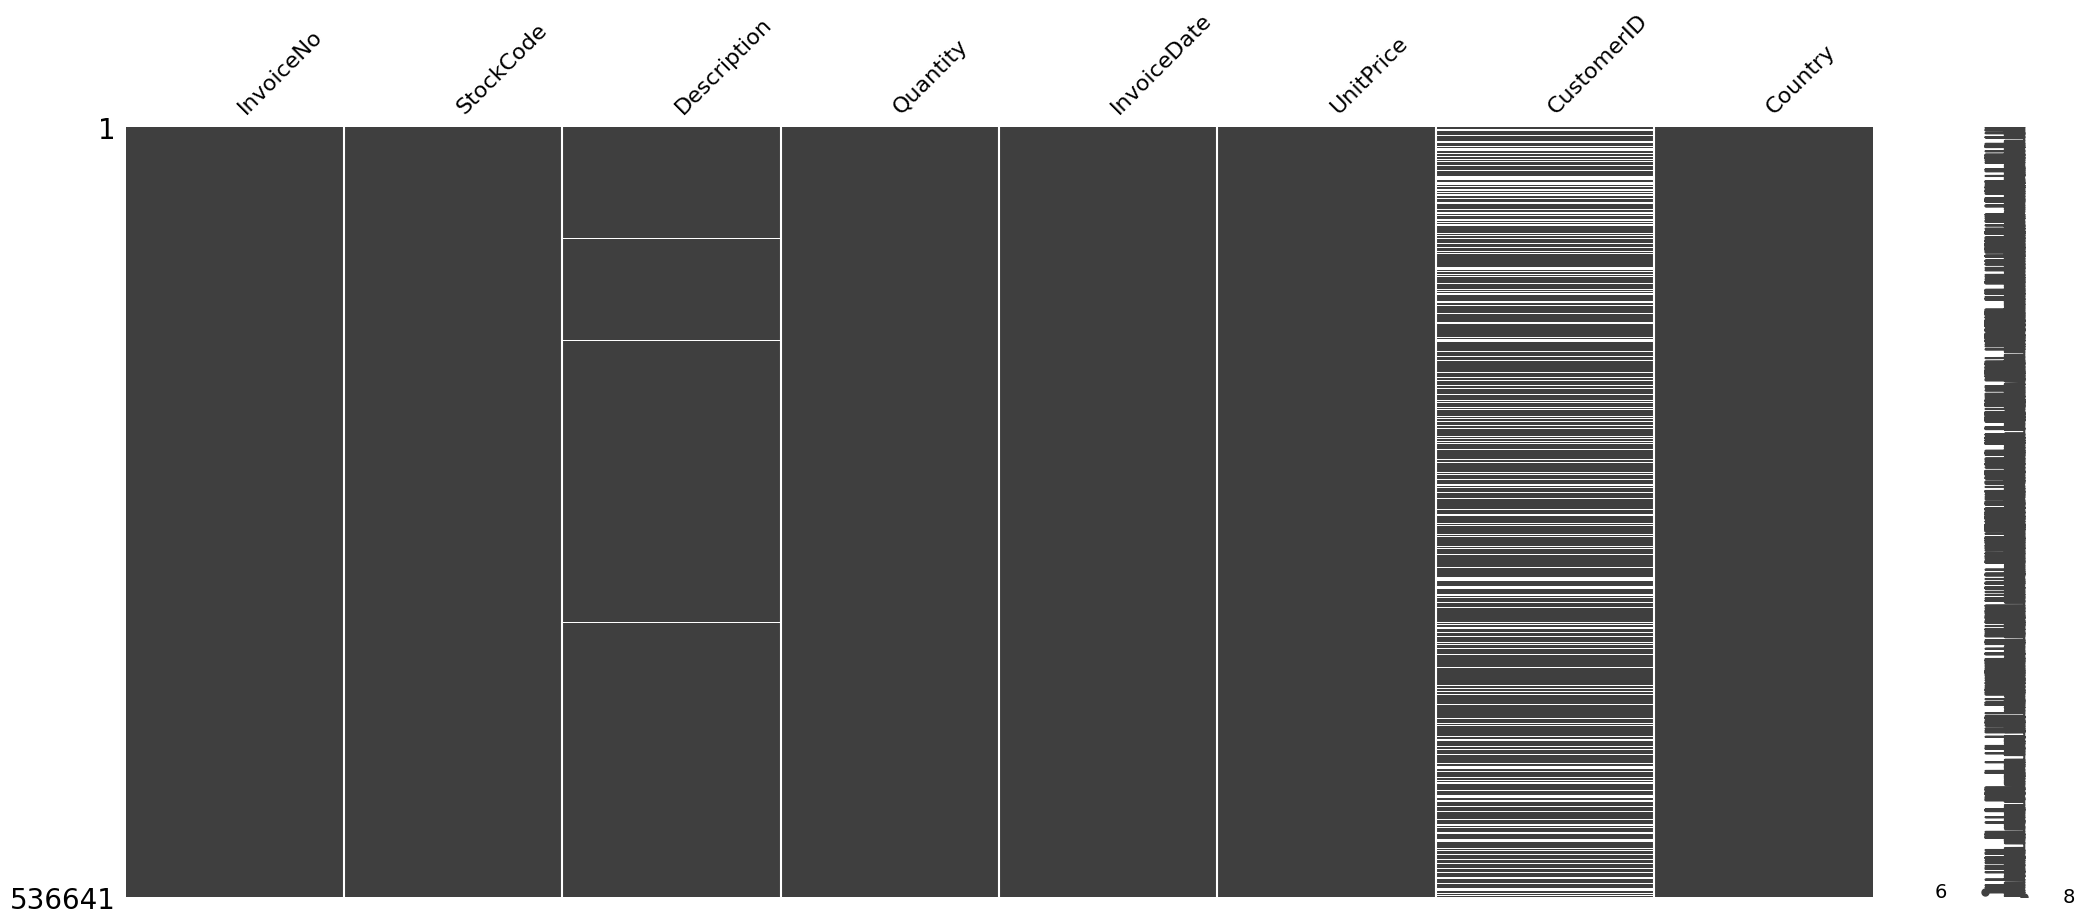

In [ ]:
msno.matrix(df);

- Nota-se uma grande quantidade de dados faltantes para a coluna de identificação do cliente e alguns para a descrição do produto.

In [ ]:
## Verificando nulos na coluna Description
df[df.Description.isna()]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom


- Optou-se pelo drop das linhas em que a coluna de descrição do produto apresenta dados nulos e o mesmo para as que não possuem identificação do cliente, devido ao problema de negócio que está sendo discutido, onde são necessários estes valores.

In [ ]:
## Drop das linhas com dados nulos da coluna 'Description'

df = df.dropna()
df.stb.missing()

,missing,total,percent
InvoiceNo,0,401604,0.0
StockCode,0,401604,0.0
Description,0,401604,0.0
Quantity,0,401604,0.0
InvoiceDate,0,401604,0.0
UnitPrice,0,401604,0.0
CustomerID,0,401604,0.0
Country,0,401604,0.0


In [ ]:
# Analisando dados de preço / quantidade nulos ou negativos

df.query("UnitPrice <= 0 or Quantity <= 0")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


- Neste case serão eliminados os dados negativos e nulos em quantidades e preços, mas o ideal seria a verificação para um possível tratamento, de acordo com o possível erro de lançamento.

In [ ]:
## Filtrando dataset
df_filtro = df.copy()
df_filtro = df.query('UnitPrice > 0 and Quantity > 0')
df_filtro.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Convertendo tipo na coluna InvoiceDate para data

df_filtro['InvoiceDate'] = pd.to_datetime(df_filtro['InvoiceDate'].dt.date)

# Convertendo CustomerID para object
df_filtro['CustomerID'] = df_filtro['CustomerID'].astype(int)
df_filtro.info()

<ipython-input-81-68628babe56e>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-81-68628babe56e>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


In [ ]:
df_filtro.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom


<Axes: >

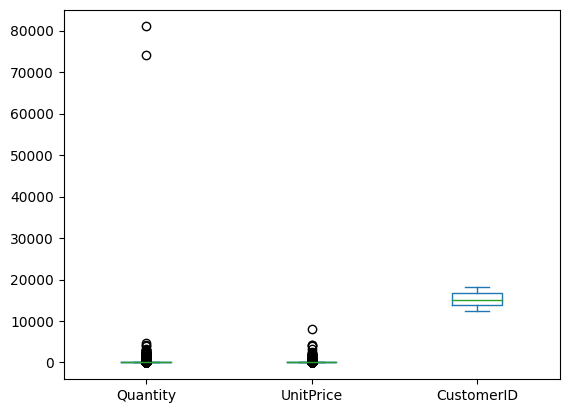

In [ ]:
# Tratando os outliers de Quantity e UnitPrice

numeric_cols = df_filtro.select_dtypes('number').columns

df_filtro[numeric_cols].plot.box()
#escala muito pequena devido a grandes outliers
#df[numeric_cols].apply(scale).plot.box()

- Mesmo com os ajustes de escala ainda é difícil de visualizar os dados por conta de outlier extremos, assim serão identificados os outliers extremos, de ambas as colunas, e filtrado o dataset para melhorar a análise dos demais dados.

In [ ]:
df_filtro.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom


In [ ]:
# Identificando maiores valores de Quantity

df_filtro.sort_values(by='Quantity',ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,16446,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27,0.21,12901,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27,0.72,13135,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22,0.82,18087,United Kingdom
...,...,...,...,...,...,...,...,...
171584,551436,22674,FRENCH TOILET SIGN BLUE METAL,1,2011-04-28,1.25,16904,United Kingdom
74255,542412,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,1,2011-01-27,2.95,16725,United Kingdom
171583,551436,22840,ROUND CAKE TIN VINTAGE RED,1,2011-04-28,7.95,16904,United Kingdom
74259,542412,22660,DOORMAT I LOVE LONDON,1,2011-01-27,7.95,16725,United Kingdom


In [ ]:
df_filtro.sort_values(by='UnitPrice',ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03,8142.750,16029,United Kingdom
422376,573080,M,Manual,1,2011-10-27,4161.060,12536,France
422351,573077,M,Manual,1,2011-10-27,4161.060,12536,France
406406,571751,M,Manual,1,2011-10-19,3949.320,12744,Singapore
374542,569382,M,Manual,1,2011-10-03,3155.950,15502,United Kingdom
...,...,...,...,...,...,...,...,...
229499,557057,16045,POPART WOODEN PENCILS ASST,100,2011-06-16,0.040,16843,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26,0.001,15618,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25,0.001,16198,United Kingdom
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15,0.001,13952,United Kingdom


- É evidente a existência de outliers bastante extremos. Devido à grande granularidade nos valores devido à natureza do negócio estudado, será adotado um filtro conforme comentado no problema de negócio (Quantidade de itens menor ou igual do que 10000 e o preço unitário menor ou igual do que 5000).

<Axes: >

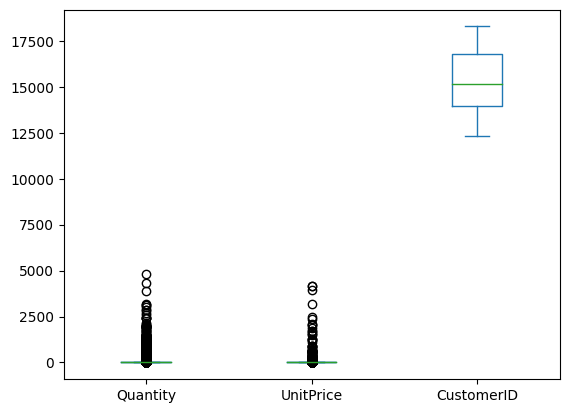

In [ ]:
# Filtro de outliers extremos

df_trat1 = df_filtro.query('UnitPrice < 5000 and Quantity < 10000')
df_trat1.describe()

numeric_cols = df_trat1.select_dtypes('number').columns

df_trat1[numeric_cols].plot.box()

- Percebe-se que ainda existe uma existência bastante grande de variação, como foge da discussão do problema de negócio, será mantida a premissa de filtro fixada, mas recomenda-se verificar se esta variação realmente faz sentido para o negócio.

In [ ]:
# Adição de coluna com preço total da compra
df_trat1['TotalPrice'] = df_trat1['UnitPrice'] * df_trat1['Quantity']
df_trat1.head()

<ipython-input-88-06bd1c6f84f5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34


In [ ]:
# Definindo Última Data de Compra no Dataset

ultima_compra = df_trat1['InvoiceDate'].max()
ultima_compra

Timestamp('2011-12-09 00:00:00')

In [ ]:
# Plotando gráfico Vendas por País (Top 10)

agg_top10country = df_trat1.groupby(['Country'])['TotalPrice'].agg('sum').sort_values(ascending=False).reset_index().head(10)
agg_top10country




,Country,TotalPrice
0,United Kingdom,7031228.694
1,Netherlands,285446.340
2,EIRE,265262.460
3,Germany,228678.400
4,France,208934.310
5,Australia,138453.810
6,Spain,61558.560
7,Switzerland,56443.950
8,Belgium,41196.340
9,Sweden,38367.830


In [ ]:
plot1 = go.Figure(go.Bar(
    y = agg_top10country['Country'],
    x = agg_top10country['TotalPrice'],
    orientation='h'))

plot1.update_layout(yaxis=dict(autorange="reversed"))
plot1.show()

- Foi seguida a premissa de plano de negócio de expor o top 10 países por venda, mas como o valor de um dos países é muito maior do que os demais recomenda-se que seja realizada a análise a parte deste país para uma apresentação visual mais adequada.

In [ ]:
agg_temp = df_trat1.groupby('Country').size().sort_values(ascending=False)
agg_temp

Country
United Kingdom          349200
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


- Verificação do porque as vendas do Reino Unido foram tão mais expressivas o que se justifica pela grande quantidade de vendas comparado com os demais países.

In [ ]:
# Plotando Top 10 produtos mais vendidos

agg_top10produtos = df_trat1.groupby(['Description'])['Quantity'].agg('sum').sort_values(ascending=False).reset_index().head(10)
agg_top10produtos

,Description,Quantity
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54319
1,JUMBO BAG RED RETROSPOT,46078
2,WHITE HANGING HEART T-LIGHT HOLDER,36706
3,ASSORTED COLOUR BIRD ORNAMENT,35263
4,PACK OF 72 RETROSPOT CAKE CASES,33670
5,POPCORN HOLDER,30919
6,RABBIT NIGHT LIGHT,27153
7,MINI PAINT SET VINTAGE,26076
8,PACK OF 12 LONDON TISSUES,25329
9,PACK OF 60 PINK PAISLEY CAKE CASES,24230


In [ ]:
plot2 = go.Figure(go.Bar(
    y = agg_top10produtos['Description'],
    x = agg_top10produtos['Quantity'],
    orientation='h'))

plot2.update_layout(yaxis=dict(autorange="reversed"))
plot2.show()

In [ ]:
df_trat1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392689 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392689 non-null  object        
 1   StockCode    392689 non-null  object        
 2   Description  392689 non-null  object        
 3   Quantity     392689 non-null  int64         
 4   InvoiceDate  392689 non-null  datetime64[ns]
 5   UnitPrice    392689 non-null  float64       
 6   CustomerID   392689 non-null  int64         
 7   Country      392689 non-null  object        
 8   TotalPrice   392689 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB


In [ ]:
df_trat1['InvoiceDate']

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541904   2011-12-09
541905   2011-12-09
541906   2011-12-09
541907   2011-12-09
541908   2011-12-09
Name: InvoiceDate, Length: 392689, dtype: datetime64[ns]

In [ ]:
# Plotando Valor de venda total por mês
df_trat1['InvoiceDate_Month'] = df_trat1['InvoiceDate'].dt.month
agg_date = df_trat1.groupby(df_trat1['InvoiceDate_Month'])['TotalPrice'].sum().reset_index()
agg_date.head(15)



<ipython-input-97-7b3205b968dc>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,InvoiceDate_Month,TotalPrice
0,1,490917.710
1,2,446084.920
2,3,594081.760
3,4,468374.331
4,5,669212.400
5,6,660046.050
6,7,598962.901
7,8,644051.040
8,9,950690.202
9,10,1035642.450


In [ ]:
plot3 = go.Figure(go.Bar(
    x = agg_date['InvoiceDate_Month'],
    y = agg_date['TotalPrice'],
    orientation='v'))

plot3.show()

In [ ]:
# Plotando gráfico valor de venda total por mês e por país

top10country = agg_top10country['Country']
filtro = df_trat1['Country'].isin(top10country)
agg_date_country = df_trat1[filtro]

In [ ]:

agg_date_country = agg_date_country.groupby(['InvoiceDate_Month','Country'])['TotalPrice'].sum().reset_index()
agg_date_country.head(15)


,InvoiceDate_Month,Country,TotalPrice
0,1,Australia,9017.71
1,1,Belgium,1200.20
2,1,EIRE,21904.19
3,1,France,17740.12
4,1,Germany,16880.84
5,1,Netherlands,26611.16
6,1,Spain,10086.09
7,1,Sweden,3486.32
8,1,Switzerland,4231.23
9,1,United Kingdom,363692.73


<Axes: xlabel='InvoiceDate_Month', ylabel='TotalPrice'>

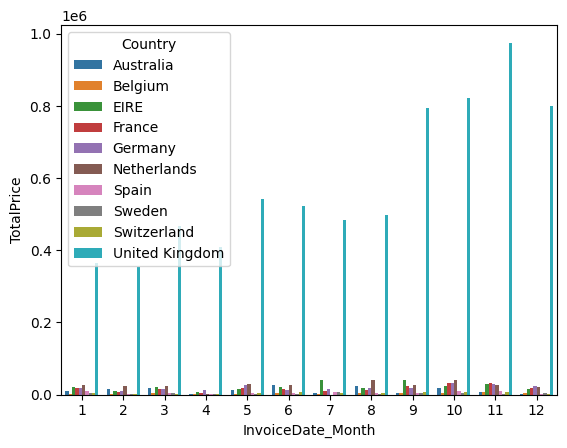

In [ ]:
sns.barplot(agg_date_country, x = 'InvoiceDate_Month', y = 'TotalPrice', hue = 'Country')

- O mesmo dito para o top 10 países em vendas se aplica a este gráfico.

In [ ]:
# Cálculo do RFM (Frequência)

agg_clientF = df_trat1.groupby(['CustomerID'])['InvoiceNo'].count().reset_index()
agg_clientF.head()



,CustomerID,InvoiceNo
0,12347,182
1,12348,31
2,12349,73
3,12350,17
4,12352,85


In [ ]:
# Cálculo do RFM (Ticket Médio M)

agg_clientM = df_trat1.groupby(['CustomerID'])['TotalPrice'].mean().round(2).reset_index()
agg_clientM.head()

,CustomerID,TotalPrice
0,12347,23.68
1,12348,57.98
2,12349,24.08
3,12350,19.67
4,12352,29.48


In [ ]:
# Cálculo do RMF (Recência R)

agg_clientR = df_trat1.groupby(['CustomerID'])['InvoiceDate'].max().reset_index()
agg_clientR['R'] = (ultima_compra - agg_clientR['InvoiceDate']).dt.days
agg_clientR.head()

,CustomerID,InvoiceDate,R
0,12347,2011-12-07,2
1,12348,2011-09-25,75
2,12349,2011-11-21,18
3,12350,2011-02-02,310
4,12352,2011-11-03,36


In [ ]:
# Unindo as tabelas

agg_clientRMF = agg_clientR.drop(columns=['InvoiceDate'])
agg_clientRMF['M'] = agg_clientM['TotalPrice']
agg_clientRMF['F'] = agg_clientF['InvoiceNo']
agg_clientRMF.head()

,CustomerID,R,M,F
0,12347,2,23.68,182
1,12348,75,57.98,31
2,12349,18,24.08,73
3,12350,310,19.67,17
4,12352,36,29.48,85
